In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

# Import Dataset

In [2]:
hydroswot = pd.read_csv('./HYDRoSWOT/SWOT_ADCP_Dataset.csv', converters={'site_no': str}, low_memory=False)

In [3]:
hydroswot.head()

,host,agency_cd,site_no,station_nm,dec_lat_va,dec_long_va,coord_datum_cd,drain_area_va,contrib_drain_area_va,alt_va,...,q6_JRatio,q6_JRatioGTo582,q6_JRatioLTo836,q7_max_vel_D_mean_vel,q7_max_vel_D_mean_vel_LT2,q8_stream_width_D_mean_depth,q8_GT2,q8_LT200,q9_stream_width_GT100,q10_mean_vel_GTo5
0,NWISAR,USGS,07040070,"Wilhelmina Cut-Off near Campbell, MO",36.514722,-90.157222,NAD83,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0
1,NWISAR,USGS,07040070,"Wilhelmina Cut-Off near Campbell, MO",36.514722,-90.157222,NAD83,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0
2,NWISAR,USGS,07040070,"Wilhelmina Cut-Off near Campbell, MO",36.514722,-90.157222,NAD83,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0
3,NWISAR,USGS,07040070,"Wilhelmina Cut-Off near Campbell, MO",36.514722,-90.157222,NAD83,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0
4,NWISAR,USGS,07040070,"Wilhelmina Cut-Off near Campbell, MO",36.514722,-90.157222,NAD83,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0


In [3]:
candidate_columns = ['site_no', 'drain_area_va', 'q_va', 'stage_va', 'stream_wdth_va', 'xsec_area_va', 'mean_vel_va', 'mean_depth_va']
hydroswot = hydroswot[candidate_columns]

In [12]:
no_zero = hydroswot[(hydroswot['drain_area_va'] != 0) & (hydroswot['q_va'] > 0) & (hydroswot['stage_va'] > 0) & (hydroswot['stream_wdth_va'] != 0) & (hydroswot['xsec_area_va'] != 0) & (hydroswot['mean_vel_va'] > 0) & (hydroswot['mean_depth_va'] != 0)]

In [13]:
no_nan = no_zero.dropna(axis=0)

In [16]:
no_nan.describe()

,drain_area_va,q_va,stage_va,stream_wdth_va,xsec_area_va,mean_vel_va,mean_depth_va
count,4.749100e+04,4.749100e+04,47491.000000,47491.000000,47491.000000,47491.000000,47491.000000
mean,2.396567e+04,1.082973e+04,14.369585,239.598811,3409.567784,1.933733,6.726717
std,1.071546e+05,5.901734e+04,65.111289,387.476461,14080.534770,1.661404,7.281574
min,1.000000e-02,1.160000e-01,0.007500,2.550000,1.080000,0.001000,0.510000
25%,2.120000e+02,2.409495e+02,3.440000,70.565500,199.041500,0.839000,2.677500
50%,7.750000e+02,8.234410e+02,5.750000,124.273000,545.910000,1.614000,4.500000
75%,3.180000e+03,3.159236e+03,10.460000,249.985000,1639.822500,2.680000,7.966500
max,1.144500e+06,2.257500e+06,2991.380000,16361.950000,357000.000000,95.000000,118.770000


In [10]:
no_nan.shape

(48146, 8)

In [15]:
no_nan['site_no'].value_counts().describe()

count    5469.000000
mean        8.683672
std        10.517488
min         1.000000
25%         2.000000
50%         5.000000
75%        12.000000
max       155.000000
Name: site_no, dtype: float64

In [44]:
candidates = no_nan[['drain_area_va', 'q_va', 'stage_va', 'stream_wdth_va', 'xsec_area_va', 'mean_vel_va', 'mean_depth_va']]
candidates.reset_index(inplace=True, drop=True)

In [72]:
candidates = candidates[candidates > candidates.quantile(0.05)]
candidates = candidates[candidates < candidates.quantile(0.95)]

In [73]:
candidates.shape

(47491, 7)

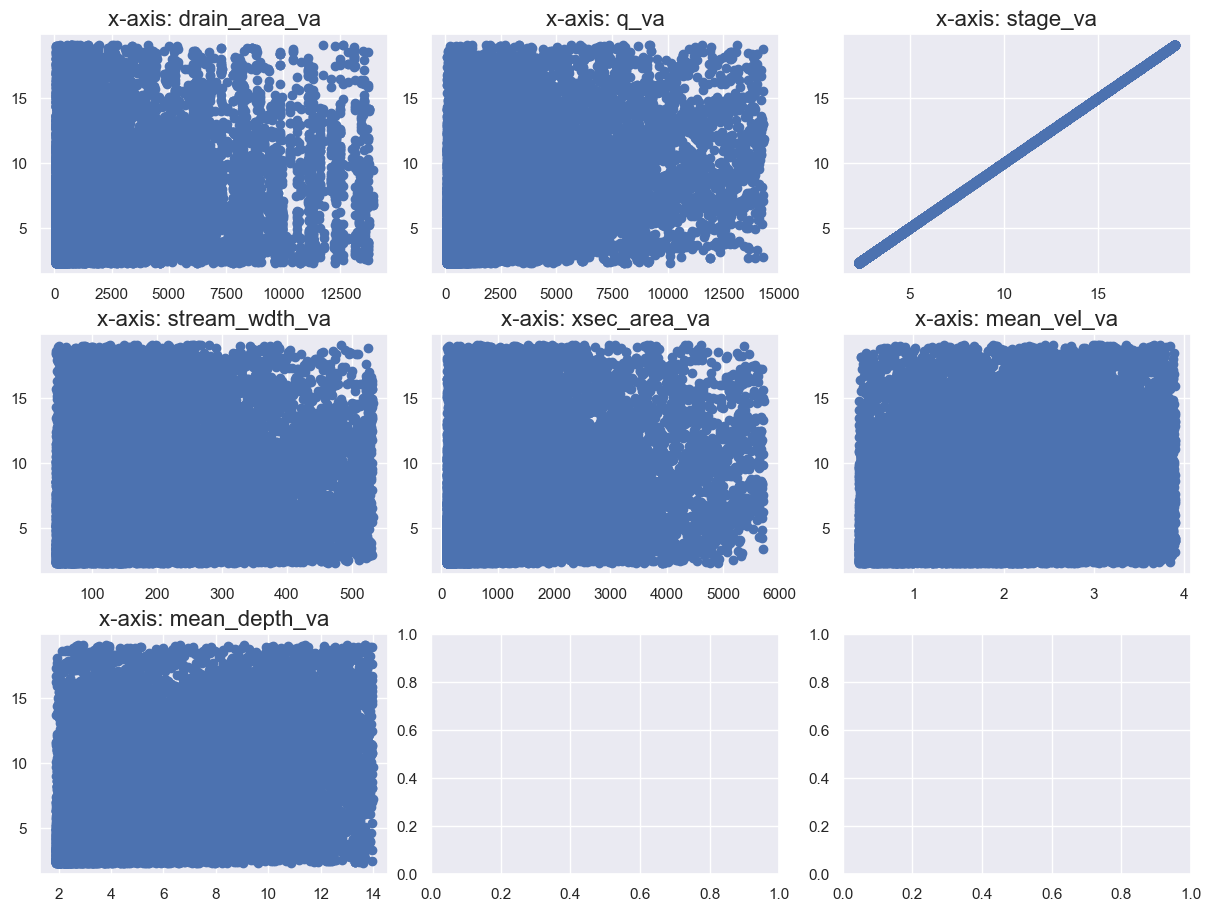

In [74]:
fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(12, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(candidates.iteritems()):
    i, j = divmod(index, 3)

    axes[i, j].scatter(column_data, candidates['stage_va'])
    axes[i, j].set_title(f'x-axis: {column_name}', fontsize=16)
    # axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

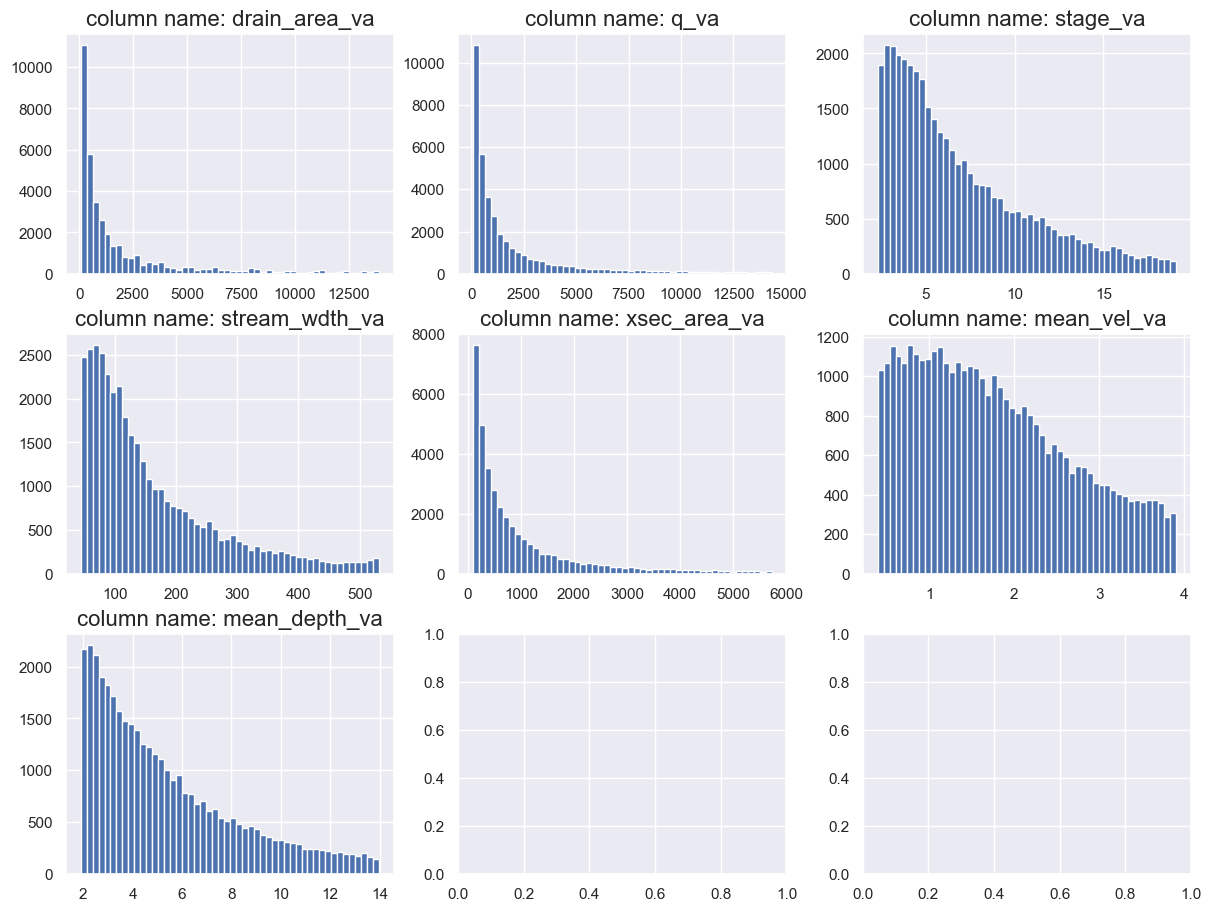

In [75]:
fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(12, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(candidates.iteritems()):
    i, j = divmod(index, 3)

    axes[i, j].hist(column_data, bins=50)
    axes[i, j].set_title(f'column name: {column_name}', fontsize=16)
    # axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

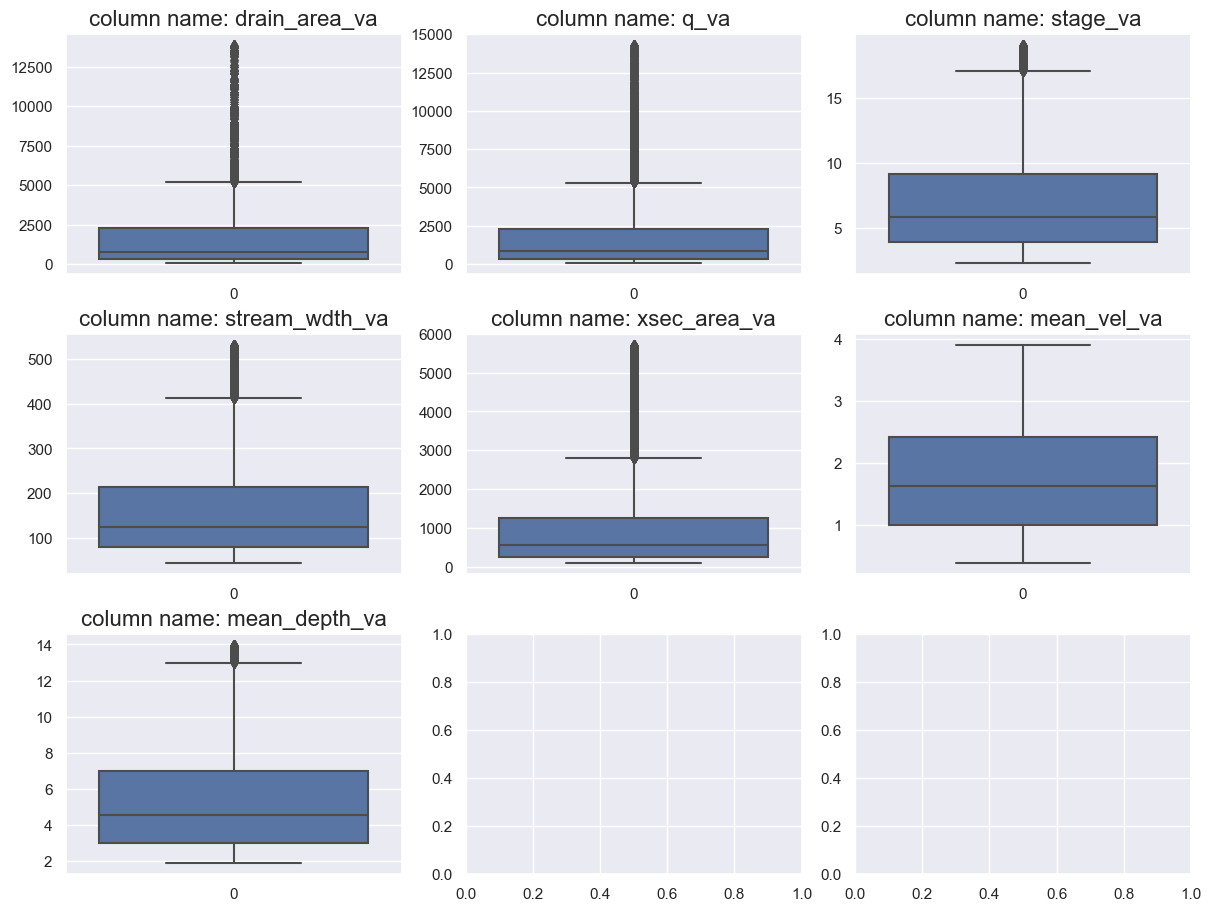

In [76]:
# Boxplot
fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(12, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(candidates.iteritems()):
    i, j = divmod(index, 3)

    sns.boxplot(data=column_data, orient='v', ax=axes[i, j])
    axes[i, j].set_title(f'column name: {column_name}', fontsize=16)
    # axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

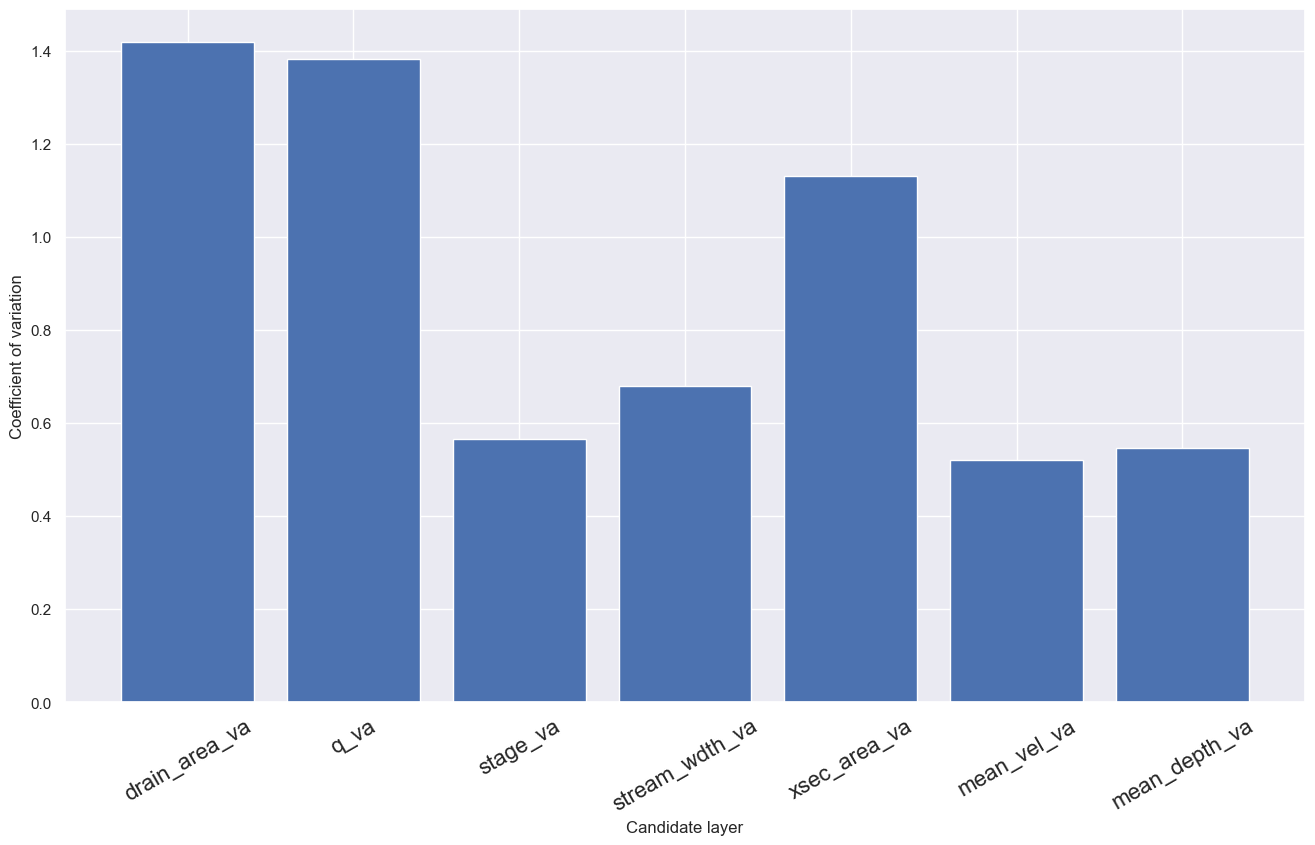

In [77]:
# coefficient of variation
cv_df = candidates.std() / candidates.mean()
cv_df = cv_df.reset_index().rename(columns={'index':'layer_name', 0:'cv'})
fig, ax = plt.subplots(figsize=(16,9))

ax.bar(cv_df['layer_name'], cv_df['cv'])
ax.tick_params(axis='x', labelrotation=30, labelsize=16)
ax.set_xlabel('Candidate layer')
ax.set_ylabel('Coefficient of variation')

# plt.savefig(f'{data_root}/results/cv.png')
plt.show()